In [1]:
import os

import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from math import pi
import seaborn as sns
%matplotlib inline 

import warnings
warnings.filterwarnings("ignore")

# Print all rows and columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
IS_LOCAL = True

import os

if IS_LOCAL:
    PATH="input"
else:
    PATH="../input"
print(os.listdir(PATH))

['train.csv.zip', 'test.csv', 'sample_submission.csv.zip', 'test.csv.zip', 'train.csv', 'sample_submission.csv']


In [2]:
train_df = pd.read_csv(os.path.join(PATH, "train.csv"))
test_df = pd.read_csv(os.path.join(PATH, "test.csv"))

In [3]:
train_y = np.log1p(train_df["target"].values)
train_X = train_df.drop(["ID", "target"], axis=1)
test_X = test_df.drop(["ID"], axis=1)

In [10]:
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
from sklearn.decomposition import PCA, FastICA
from sklearn.decomposition import TruncatedSVD

n_comp = 320

# tSVD
print('tsvd')
tsvd = TruncatedSVD(n_components=n_comp, random_state=420)
tsvd_results_train = tsvd.fit_transform(train_X)
tsvd_results_test = tsvd.transform(test_X)

# PCA
print('pca')
pca = PCA(n_components=n_comp, random_state=420)
pca2_results_train = pca.fit_transform(train_X)
pca2_results_test = pca.transform(test_X)

# ICA
print('ica')
ica = FastICA(n_components=n_comp, random_state=420)
ica2_results_train = ica.fit_transform(train_X)
ica2_results_test = ica.transform(test_X)

# GRP
print('grp')
grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=420)
grp_results_train = grp.fit_transform(train_X)
grp_results_test = grp.transform(test_X)

# SRP
print('srp')
srp = SparseRandomProjection(n_components=n_comp, dense_output=True, random_state=420)
srp_results_train = srp.fit_transform(train_X)
srp_results_test = srp.transform(test_X)



tsvd
pca
ica
grp
srp


NameError: name 'train' is not defined

In [11]:
# Append decomposition components to datasets
for i in range(1, n_comp + 1):
    train_X['pca_' + str(i)] = pca2_results_train[:, i - 1]
    test_X['pca_' + str(i)] = pca2_results_test[:, i - 1]

    train_X['ica_' + str(i)] = ica2_results_train[:, i - 1]
    test_X['ica_' + str(i)] = ica2_results_test[:, i - 1]

    train_X['tsvd_' + str(i)] = tsvd_results_train[:, i - 1]
    test_X['tsvd_' + str(i)] = tsvd_results_test[:, i - 1]

    train_X['grp_' + str(i)] = grp_results_train[:, i - 1]
    test_X['grp_' + str(i)] = grp_results_test[:, i - 1]

    train_X['srp_' + str(i)] = srp_results_train[:, i - 1]
    test_X['srp_' + str(i)] = srp_results_test[:, i - 1]

y_mean = np.mean(train_y)

In [12]:
y_mean

14.490239292748585

In [15]:
import xgboost as xgb

def run_xgb(train_X, train_y, val_X, val_y, test_X):
    params =  {
      "objective"           : "reg:linear",
      "eval_metric"         : "rmse",
      "eta"                 : 0.01,
      "max_depth"           : 4,
      #"min_child_weight"    : 6,
      #"gamma"               : 10,
      "subsample"           : 0.7,
      "colsample_bytree"    : 0.5,
      #"alpha"               : 16,
      #"lambda"              : 1,
      #'tree_method'       : 'hist',
      'nthread'           : 8,
      'base_score' : 14.5,
       #'max_delta_step'    : 1,
       #'scale_pos_weight' : 3
    }
    dtrain = xgb.DMatrix(train_X, label=train_y)
    dval = xgb.DMatrix(val_X, label=val_y)
    dtest = xgb.DMatrix(test_X)
    evallist = [(dtrain, 'train'), (dval, 'eval')]
    num_round = 5000
    bst = xgb.train(params, dtrain, num_round, evallist, early_stopping_rounds=200, verbose_eval=200)
    
    pred_test_y = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)
    return pred_test_y, bst, {}



In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import preprocessing, model_selection, metrics
import lightgbm as lgb

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
pred_test_full = 0
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_test, model, evals_result = run_xgb(dev_X, dev_y, val_X, val_y, test_X)
    pred_test_full += pred_test
pred_test_full /= 5.
pred_test_full = np.expm1(pred_test_full)

[0]	train-rmse:1.75768	eval-rmse:1.70045
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 200 rounds.
[200]	train-rmse:1.33356	eval-rmse:1.43229
[400]	train-rmse:1.15758	eval-rmse:1.38587
[600]	train-rmse:1.04035	eval-rmse:1.3745
[800]	train-rmse:0.945847	eval-rmse:1.36791
[1000]	train-rmse:0.861842	eval-rmse:1.36329
[1200]	train-rmse:0.788832	eval-rmse:1.36281
Stopping. Best iteration:
[1151]	train-rmse:0.806775	eval-rmse:1.36167

[0]	train-rmse:1.74408	eval-rmse:1.75703
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 200 rounds.
[200]	train-rmse:1.33519	eval-rmse:1.46877
[400]	train-rmse:1.15863	eval-rmse:1.40418
[600]	train-rmse:1.04073	eval-rmse:1.38472
[800]	train-rmse:0.945302	eval-rmse:1.37627
[1000]	train-rmse:0.863094	eval-rmse:1.37192
[1200]	train-rmse:0.789489	eval-rmse:1.36928
[1400]	train-rmse:0.722739	eval-r

In [17]:
sub_df = pd.DataFrame({"ID":test_df["ID"].values})
sub_df["target"] = pred_test_full
sub_df.to_csv("baseline_xgb.csv", index=False)

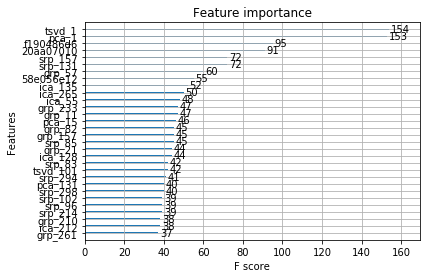

In [18]:
xgb.plot_importance(model, max_num_features=30)